# Implementation of the *clusterITE* library

### Generate Data

In [1]:
from gen_dat import gen_data

# Generate data with 10000 points, 2 features, and 3 clusters
X, y, _, _ = gen_data(n=100, p=2, K=3, eigen=[2, 3], verbose=True)

cluster 1: 44 points
cluster 2: 17 points
cluster 3: 39 points


In [2]:
from sklearn.model_selection import train_test_split

# train test split with 30% test data, 70% train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Minimal implementation

In [3]:
from clusterITE import *

2023-08-17 15:55:03.590740: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### All parametric

1. Pick the optimal number of cluster via cross-validation

100%|██████████| 14/14 [00:36<00:00,  2.58s/it]


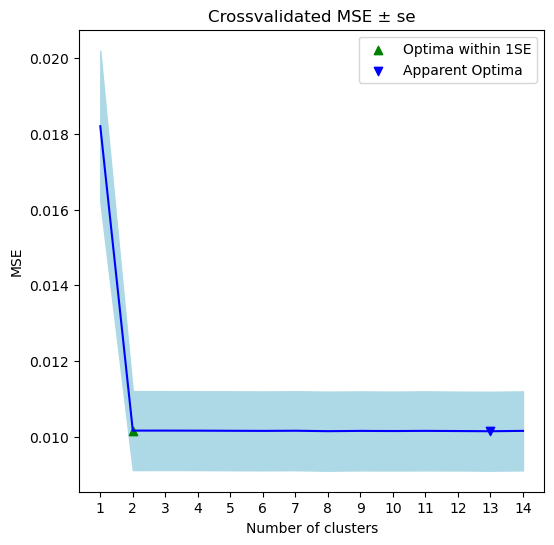

In [4]:
# Instanciate a ClusterIte model with 5 fold cross-validation
cv_model = ClusterIte_cv(nb_folds=5)

# Specify a range for the no. of clusters and fit this model to the data
cv_model.fit(X_train, y_train, cluster_range = range(1, 15))

# Plot the result
cv_model.plot()

2. Train a clusterITE model on all the data

In [5]:
# Instanciate a ClusterIte model with the optimal K estimated from cross-validation
final_model = ClusterIte(K=cv_model.best_K)

# Instanciate this model on all the training data
final_model.fit(X_train, y_train)

Converged at iteration 2 with accuracy on H 100.00%


3. Use your fitted model for cluster prediction and evaluation on unseen data

In [6]:
# Use the gating network of your trained model to predict the probabilities 
# of belonging to clusters 1,...,K for unseen observations
final_model.gate_predict(X_test)

array([[0.04417671, 0.10754799, 0.03319765, 0.0444767 , 0.11955408,
        0.10262164, 0.04304444, 0.05944609, 0.1059466 , 0.10847088,
        0.06589625, 0.03757594, 0.12804496],
       [0.04268359, 0.11112311, 0.02460507, 0.0328229 , 0.12805846,
        0.11026797, 0.04137367, 0.05446377, 0.12294264, 0.10509844,
        0.07394555, 0.02570268, 0.12691218],
       [0.03468344, 0.11032315, 0.03380127, 0.05109163, 0.12195148,
        0.09790067, 0.03342588, 0.05665803, 0.09162037, 0.12422842,
        0.04876949, 0.04496567, 0.15058056],
       [0.04116578, 0.10819191, 0.0343579 , 0.04780119, 0.119662  ,
        0.10057877, 0.03999401, 0.05910978, 0.10001658, 0.11357719,
        0.05946552, 0.04118667, 0.13489266],
       [0.03916642, 0.11064219, 0.0305635 , 0.04330234, 0.12410349,
        0.10329702, 0.03790037, 0.05680409, 0.1043487 , 0.11516666,
        0.05962468, 0.03639597, 0.13868457],
       [0.05053879, 0.10465784, 0.03316302, 0.04139694, 0.11645124,
        0.10395399, 0.04957

#### Non-parametric

1. Specify a model architecture

In [7]:
# For the gating network, define any Keras/Tensorflow architecture of your choice
def custom_tf_model(n_clusters):
    model = Sequential()
    ## Write your favorite architecture here...
    model.add(Dense(10, use_bias=True, activation='relu'))
    model.add(Dense(10, use_bias=True, activation='relu'))
    ## ... but make sure to finish the network like so
    model.add(Dense(n_clusters, use_bias=True, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

# For the expert networks, define any sklearn architecture of your choice
# and store both expert and gating network in a dictonary
base_learners = {'experts': RandomForestRegressor(n_estimators=100, max_depth=10, max_features=10),
                 'gating_net': custom_tf_model}

2. Pick the optimal number of cluster via cross-validation

100%|██████████| 14/14 [02:15<00:00,  9.67s/it]


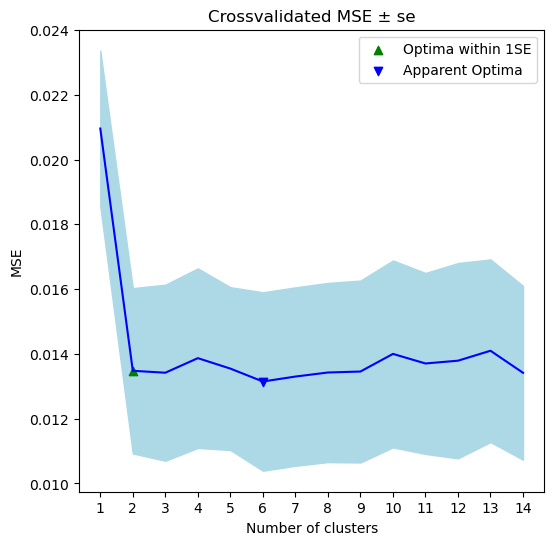

In [8]:
# Instanciate a ClusterIte model with 5 fold cross-validation
cv_model = ClusterIte_cv(nb_folds=5, **base_learners)

# Specify a range for the no. of clusters and fit this model to the data
cv_model.fit(X_train, y_train, cluster_range = range(1,15))

# Plot the result
cv_model.plot()

3. Train a clusterITE model on all the data

In [9]:
# Instanciate a ClusterIte model with the optimal K estimated from cross-validation
final_model = ClusterIte(K=cv_model.best_K, **base_learners)

# Instanciate this model on all the training data
final_model.fit(X_train, y_train)

Converged at iteration 2 with accuracy on H 100.00%


4. Use your fitted model for cluster prediction and evaluation on unseen data

In [10]:
# Use the gating network of your trained model to predict the probabilities 
# of belonging to clusters 1,...,K for unseen observations
final_model.gate_predict(X_test)

array([[0.13862847, 0.12260485, 0.14834441, 0.18788317, 0.18545716,
        0.21708196],
       [0.13606991, 0.08669343, 0.13858353, 0.20962387, 0.16970043,
        0.25932878],
       [0.13267626, 0.14374818, 0.16175687, 0.19015245, 0.18727165,
        0.18439458],
       [0.13742791, 0.1339508 , 0.15201329, 0.18745565, 0.18894981,
        0.20020257],
       [0.13545375, 0.12248988, 0.14784946, 0.19097863, 0.1879506 ,
        0.21527761],
       [0.1434651 , 0.10585875, 0.14524737, 0.19943102, 0.17523964,
        0.2307581 ],
       [0.13811906, 0.12362261, 0.14825499, 0.18815185, 0.1863987 ,
        0.21545285],
       [0.13459712, 0.04665627, 0.12082803, 0.28832692, 0.14766842,
        0.26192322],
       [0.1256646 , 0.07265794, 0.13122028, 0.20934917, 0.16465148,
        0.29645646],
       [0.12831494, 0.10237537, 0.14142932, 0.20030852, 0.18503785,
        0.24253413],
       [0.13592912, 0.12063932, 0.1470384 , 0.19064768, 0.18722594,
        0.2185194 ],
       [0.1303513 , 0

In [11]:
# Get a summary of the gating network
final_model.gating_net.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 10)                30        
                                                                 
 dense_58 (Dense)            (None, 10)                110       
                                                                 
 dense_59 (Dense)            (None, 6)                 66        
                                                                 
Total params: 206
Trainable params: 206
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Get the weigths and biases of the gating network
final_model.gating_net.get_weights()

[array([[-0.6773773 , -0.65074784,  0.10670131, -0.03944945,  0.30452293,
          0.4489177 ,  0.24032588,  0.6852552 ,  0.03455806, -0.3435435 ],
        [ 0.64434403, -0.12633449, -0.49968326, -0.399952  , -0.6514684 ,
         -0.22875701,  0.2973844 , -0.55268466, -0.16685432,  0.10157794]],
       dtype=float32),
 array([-0.05019907,  0.        ,  0.        ,  0.        ,  0.        ,
         0.06167944, -0.04565055,  0.06088646,  0.        ,  0.        ],
       dtype=float32),
 array([[ 0.49625456, -0.05662017, -0.31169212, -0.53473043,  0.5984325 ,
         -0.52321017, -0.18457422,  0.07434113,  0.37330225,  0.25625736],
        [-0.46347278, -0.34137908, -0.25754246, -0.22873294, -0.01524162,
         -0.22220269,  0.01075506, -0.42871282,  0.31741202,  0.07073808],
        [-0.14046746,  0.22816908,  0.20594144,  0.5163038 ,  0.00859135,
          0.31835604, -0.34969932,  0.3523314 ,  0.02598125,  0.46146536],
        [ 0.1924383 , -0.3631136 ,  0.31228215,  0.28867447, 

In [13]:
# Evaluate the MSE of the final model on unseen data
mean_squared_error(final_model.predict(X_test), y_test)

0.010078211167412959